In [ ]:
import tensorflow as tf
import os

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')
print('Num GPUs Available:', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 1


In [ ]:
import cv2
import imghdr
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path = "/content/drive/MyDrive/collages"

train_2_5 = glob.glob(train_path+"/2.5/*.jpg")
train_3 = glob.glob(train_path+"/3.0/*.jpg")
train_3_5 = glob.glob(train_path+"/3.5/*.jpg")
train_4 = glob.glob(train_path+"/4.0/*.jpg")
train_4_5 = glob.glob(train_path+"/4.5/*.jpg")
train_5 = glob.glob(train_path+"/5.0/*.jpg")

In [ ]:
import pandas as pd

In [ ]:
import numpy as np
#Train list:
train_list = [x for x in train_2_5]
train_list.extend([x for x in train_3])
train_list.extend([x for x in train_3_5])
train_list.extend([x for x in train_4])
train_list.extend([x for x in train_4_5])
train_list.extend([x for x in train_5])
df_train = pd.DataFrame(np.concatenate([
                       ['0']*len(train_2_5),
                       ['1']*len(train_3),
                       ['2']*len(train_3_5),
                       ['3']*len(train_4),
                       ['4']*len(train_4_5),
                       ['5']*len(train_5)]),
                  columns = ['label'])
df_train['image'] = [x for x in train_list]

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


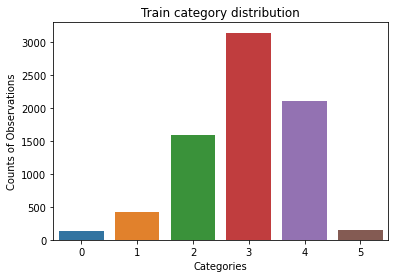

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(df_train['label'])
plt.title('Train category distribution')
plt.xlabel('Categories')
plt.ylabel('Counts of Observations')
plt.show()

In [ ]:
#List of image:
img_list = list(df_train['image'])
data_img = []
for each in img_list:
  #Each image path:
  each_path = os.path.join(train_path, each)
  #Read each image:
  each_img = cv2.imread(each_path)
  #OpenCv default color is BGR. Convert it to RGB:
  each_img = cv2.cvtColor(each_img, cv2.COLOR_BGR2RGB)
  #Resize the images:
  each_img_resized = cv2.resize(each_img, (128, 128))
  #Save arrays to a list:
  data_img.append(each_img_resized)
# Converting list to numpy array
X_train = np.array(data_img)

In [ ]:
print('Shape of X train: ', X_train.shape)

Shape of X train:  (7538, 128, 128, 3)


In [ ]:
from sklearn.preprocessing import OneHotEncoder
y_train = OneHotEncoder(dtype='int8', sparse=False).fit_transform(df_train['label'].values.reshape(-1,1))

In [ ]:
print('Shape of y train: ', y_train.shape)

Shape of y train:  (7538, 6)


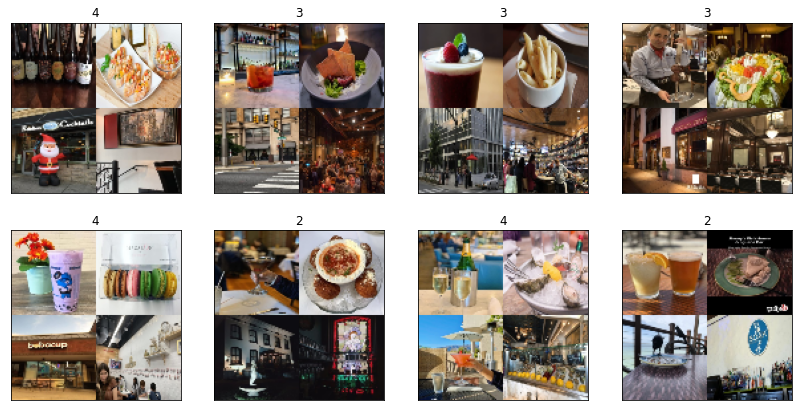

In [ ]:
indices = np.random.randint(0,6737,8)
i = 1
plt.figure(figsize=(14,7))
for each in indices:
  plt.subplot(2,4,i)
  plt.imshow(X_train[each])
  plt.title(df_train['label'].loc[each])
  plt.xticks([])
  plt.yticks([])
  i += 1

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape:  (5125, 128, 128, 3)
y_train shape:  (5125, 6)
X_val shape  :  (1282, 128, 128, 3)
y_val shape  :  (1282, 6)
X_test shape :  (1131, 128, 128, 3)
y_test shape :  (1131, 6)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Softmax
from tensorflow.keras.layers import BatchNormalization

# Defining the CNN architecture
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(2, 2), strides=2, padding='valid', activation='relu', input_shape=(128, 128, 3))) # Output shape = (64, 64, 8)
model.add(Conv2D(filters=16, kernel_size=(2, 2), strides=2, padding='valid', activation='relu')) # Output shape = (32, 32, 16)
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2)) # Output shape = (16, 16, 16)
model.add(BatchNormalization())
model.add(Conv2D(filters=24, kernel_size=(4, 4), strides=4, padding='valid', activation='relu')) # Output shape = (8, 8, 24)
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2)) # Output shape = (4, 4, 24)
model.add(BatchNormalization())
model.add(Flatten()) # Output shape = (384,)
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 8)         104       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 16)        528       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 24)          6168      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 24)        

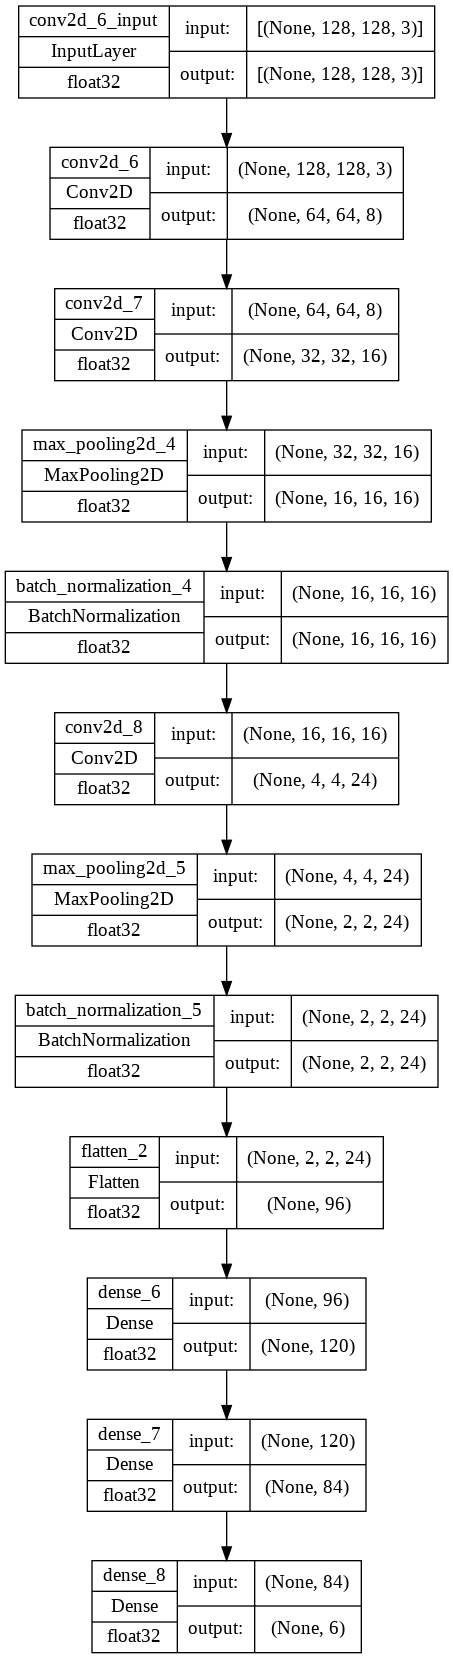

In [ ]:
tf.keras.utils.plot_model(
            model,
            to_file="model.png",
            show_shapes=True,
            show_dtype=True,
            show_layer_names=True,
            rankdir="TB",
            expand_nested=False,
            dpi=96,
            layer_range=None,
)

In [ ]:
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
batch_size = 64
epochs = 10
hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, callbacks=[tensorboard_callback])

Epoch 1/10
81/81 [==============================] - 3s 39ms/step - loss: 1.4091 - accuracy: 0.3922 - val_loss: 1.4676 - val_accuracy: 0.3175
Epoch 2/10
81/81 [==============================] - 3s 32ms/step - loss: 1.2318 - accuracy: 0.4820 - val_loss: 1.3208 - val_accuracy: 0.4353
Epoch 3/10
81/81 [==============================] - 3s 32ms/step - loss: 1.1199 - accuracy: 0.5448 - val_loss: 1.2919 - val_accuracy: 0.4423
Epoch 4/10
81/81 [==============================] - 3s 33ms/step - loss: 0.9980 - accuracy: 0.5938 - val_loss: 1.2718 - val_accuracy: 0.4696
Epoch 5/10
81/81 [==============================] - 3s 35ms/step - loss: 0.8804 - accuracy: 0.6574 - val_loss: 1.2491 - val_accuracy: 0.4945
Epoch 6/10
81/81 [==============================] - 3s 34ms/step - loss: 0.7299 - accuracy: 0.7298 - val_loss: 1.2374 - val_accuracy: 0.5133
Epoch 7/10
81/81 [==============================] - 3s 37ms/step - loss: 0.6235 - accuracy: 0.7754 - val_loss: 1.3021 - val_accuracy: 0.5156
Epoch 8/10
81

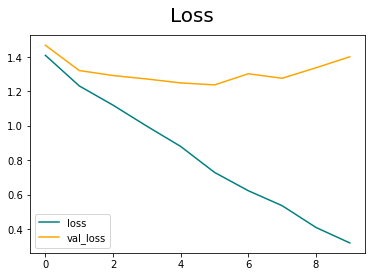

In [ ]:
fig = plt.figure()
plt.plot(range(epochs), hist.history['loss'], color='teal', label='loss')
plt.plot(range(epochs), hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="best")
plt.show()

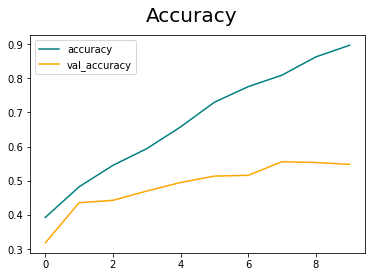

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

36/36 [==============================] - 0s 8ms/step


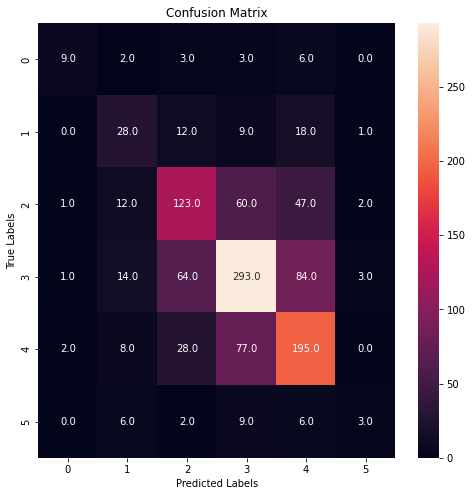

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predicting labels from X_test data
y_pred = model.predict(X_test)
# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)
# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)
# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

In [ ]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.69      0.39      0.50        23
           1       0.40      0.41      0.41        68
           2       0.53      0.50      0.52       245
           3       0.65      0.64      0.64       459
           4       0.55      0.63      0.59       310
           5       0.33      0.12      0.17        26

    accuracy                           0.58      1131
   macro avg       0.53      0.45      0.47      1131
weighted avg       0.57      0.58      0.57      1131



In [ ]:
test_loss = model.evaluate(X_test, y_test)

36/36 [==============================] - 1s 19ms/step - loss: 1.3784 - accuracy: 0.5756


In [ ]:
val_loss = model.evaluate(X_val, y_val)

41/41 [==============================] - 1s 31ms/step - loss: 1.4006 - accuracy: 0.5476


Regression

In [ ]:
X_train = np.array(data_img)
y_train = df_train['label'].to_numpy(dtype='int8')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape:  (5125, 128, 128, 3)
y_train shape:  (5125,)
X_val shape  :  (1282, 128, 128, 3)
y_val shape  :  (1282,)
X_test shape :  (1131, 128, 128, 3)
y_test shape :  (1131,)


In [ ]:
# Defining the CNN architecture
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(2, 2), strides=2, padding='valid', activation='relu', input_shape=(128, 128, 3))) # Output shape = (64, 64, 8)
model.add(Conv2D(filters=16, kernel_size=(2, 2), strides=2, padding='valid', activation='relu')) # Output shape = (32, 32, 16)
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2)) # Output shape = (16, 16, 16)
model.add(BatchNormalization())
model.add(Conv2D(filters=24, kernel_size=(4, 4), strides=4, padding='valid', activation='relu')) # Output shape = (8, 8, 24)
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2)) # Output shape = (4, 4, 24)
model.add(BatchNormalization())
model.add(Flatten()) # Output shape = (384,)
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(1, activation='linear'))

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 64, 64, 8)         104       
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 16)        528       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 16, 16, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_26 (Conv2D)          (None, 4, 4, 24)          6168      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 2, 2, 24)        

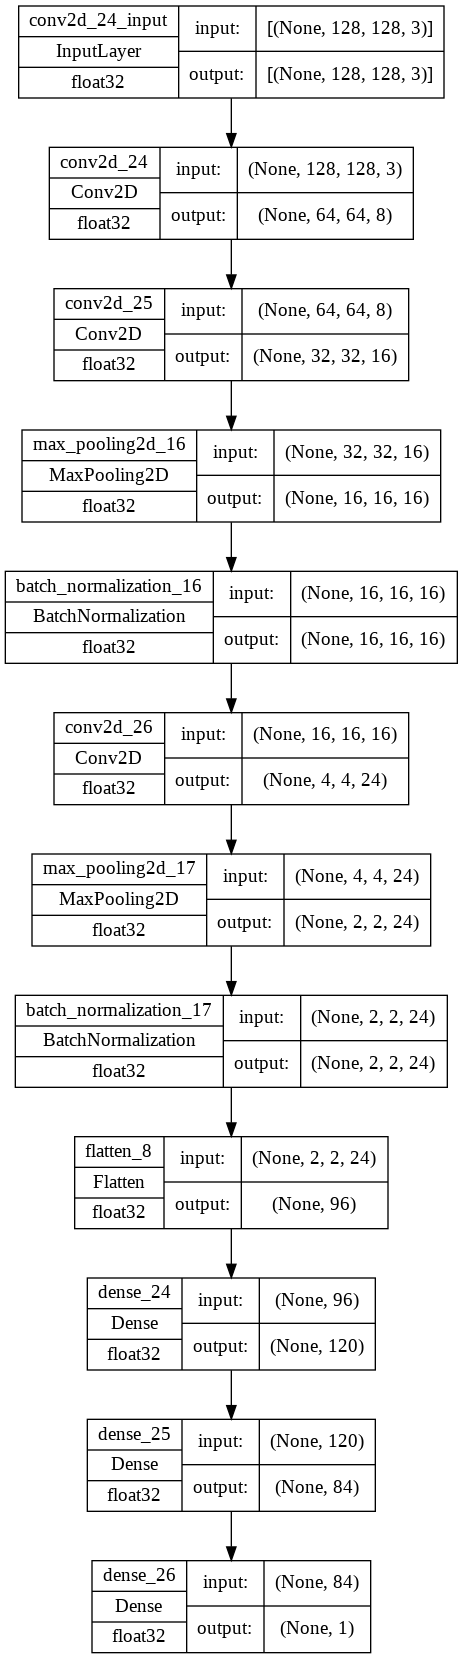

In [ ]:
tf.keras.utils.plot_model(
            model,
            to_file="model.png",
            show_shapes=True,
            show_dtype=True,
            show_layer_names=True,
            rankdir="TB",
            expand_nested=False,
            dpi=96,
            layer_range=None,
)

In [ ]:
model.compile('adam', loss='mean_squared_error', metrics=['accuracy'], run_eagerly=True)

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
batch_size = 64
epochs = 10
hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, callbacks=[tensorboard_callback])

Epoch 1/10
81/81 [==============================] - 3s 33ms/step - loss: 1.4439 - accuracy: 0.0539 - val_loss: 1.1029 - val_accuracy: 0.0554
Epoch 2/10
81/81 [==============================] - 2s 30ms/step - loss: 0.8159 - accuracy: 0.0546 - val_loss: 1.1181 - val_accuracy: 0.0554
Epoch 3/10
81/81 [==============================] - 3s 32ms/step - loss: 0.6358 - accuracy: 0.0546 - val_loss: 0.9388 - val_accuracy: 0.0554
Epoch 4/10
81/81 [==============================] - 3s 32ms/step - loss: 0.5029 - accuracy: 0.0548 - val_loss: 0.7903 - val_accuracy: 0.0554
Epoch 5/10
81/81 [==============================] - 3s 31ms/step - loss: 0.4093 - accuracy: 0.0552 - val_loss: 0.7751 - val_accuracy: 0.0554
Epoch 6/10
81/81 [==============================] - 2s 29ms/step - loss: 0.3359 - accuracy: 0.0556 - val_loss: 0.7615 - val_accuracy: 0.0554
Epoch 7/10
81/81 [==============================] - 2s 31ms/step - loss: 0.2590 - accuracy: 0.0566 - val_loss: 0.7674 - val_accuracy: 0.0554
Epoch 8/10
81

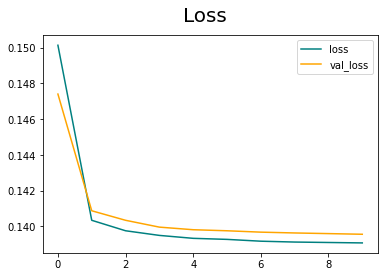

In [ ]:
fig = plt.figure()
plt.plot(range(epochs), hist.history['loss'], color='teal', label='loss')
plt.plot(range(epochs), hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="best")
plt.show()

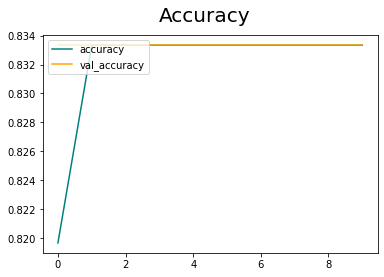

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()